In [1]:
import os
from os import path
import sys
import math
import cv2 # Read raw image
import glob
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
import subprocess
from PIL import Image
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pprint import pprint
from tqdm import tqdm, tqdm_notebook

random.seed(165)

In [2]:
# DATA_PATH = "/home/satyarth934/data/modis_data_products/*/array_3bands_normalized/448/*"
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*" # <- needs to be normalized
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed/*" # <- needs to be normalized
DATA_PATH = "/home/satyarth934/data/nasa_impact/hurricanes/*/*"
MODEL_NAME = "baseAE_hurricane_try3"
BASE_DIR = "/home/satyarth934/code/FDL_2020/"
NORMALIZE = True
SAVE_FILES = True

OUTPUT_MODEL_PATH = BASE_DIR + "Models/" + MODEL_NAME
TENSORBOARD_LOG_DIR = BASE_DIR + "tb_logs/" + MODEL_NAME
ACTIVATION_IMG_PATH = BASE_DIR + "activation_viz/" + MODEL_NAME

FEATURES_PARENT_DIR = BASE_DIR + "Features/" + MODEL_NAME
PATH_LIST = FEATURES_PARENT_DIR + "/filenames1819.pkl"
FEATURES_OUTPUT = FEATURES_PARENT_DIR + "/features1819.pkl"

# NUM_EPOCHS = 200

# dust_labels = {0: "Dust", 1: "Hazy", 2: "No Dust"}

In [3]:
X_test_paths = pickle.load(file=open((PATH_LIST), 'rb'))
feature_list = pickle.load(file=open((FEATURES_OUTPUT), 'rb'))

In [4]:
num_images = len(X_test_paths)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  2623
Number of features per image =  3920


In [5]:
# Use scikit-learn to find Nearest Neighbors
neighbors = NearestNeighbors(n_neighbors=50,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

In [6]:
# wind_speed in knots
def getCategory(wind_speed):
    if wind_speed <= 33:
        return 'TD'
    elif 34 <= wind_speed <= 63:
        return 'TS'
    elif 64 <= wind_speed <= 82:
        return 'C1'
    elif 83 <= wind_speed <= 95:
        return 'C2'
    elif 96 <= wind_speed <= 112:
        return 'C3'
    elif 113 <= wind_speed <= 136:
        return 'C4'
    elif wind_speed >= 137:
        return 'C5'


def classname(str):    
    file_name = str.split("/")[-1]
    wind_speed = int(file_name.split(".")[0].split("_")[-1].strip("kts"))
    return getCategory(wind_speed)


# Helper function to get the classname and filename
def classname_filename(filepath):
    file_name = filepath.split("/")[-1]
    return str(classname(filepath)) + '/' + file_name.split("_")[0] + "_" + file_name.split("_")[-1]


# Normalize the image to plot
def normalize(mat):
    normalized = (mat - np.nanmin(mat)) / (np.nanmax(mat) - np.nanmin(mat))
    return normalized


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances, dims):
    images = []
    for filename in filenames:
        np_img = resize(plt.imread((filename))[:,:,:3], dims)
        if NORMALIZE:
            np_img = normalize(np_img)
        
        images.append(np_img)
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
    # To save the plot in a high definition format i.e. PDF, uncomment the following line:
    if SAVE_FILES:
        file_parent = BASE_DIR + "Features/Images/" + MODEL_NAME
        subprocess.call("mkdir -p " + file_parent, shell=True)
        output_path = file_parent + "/similar_%s_%s.pdf" % (filenames[i].split('/')[-1].split(".")[1], classname(filenames[i]))
        plt.savefig(output_path, format='pdf', dpi=1000)
    # We will use this line repeatedly in our code.

68
[  68 1159  776 2023  106  298  525 2542 1247 1572  855  339 1077 1658
 2294]
[0.0, 0.46, 0.6, 0.6, 0.61, 0.62, 0.64, 0.65, 0.65, 0.65, 0.66, 0.66, 0.66, 0.66, 0.66]
['ep162018_advTime_20180901T000000_goesTime_20180901T052055_intensity_100kts.png',
 'ep162018_advTime_20180901T060000_goesTime_20180901T072055_intensity_90kts.png',
 'al102019_advTime_20190917T000000_goesTime_20190917T002504_intensity_25kts.png',
 'al022019_advTime_20190712T180000_goesTime_20190712T222522_intensity_55kts.png']


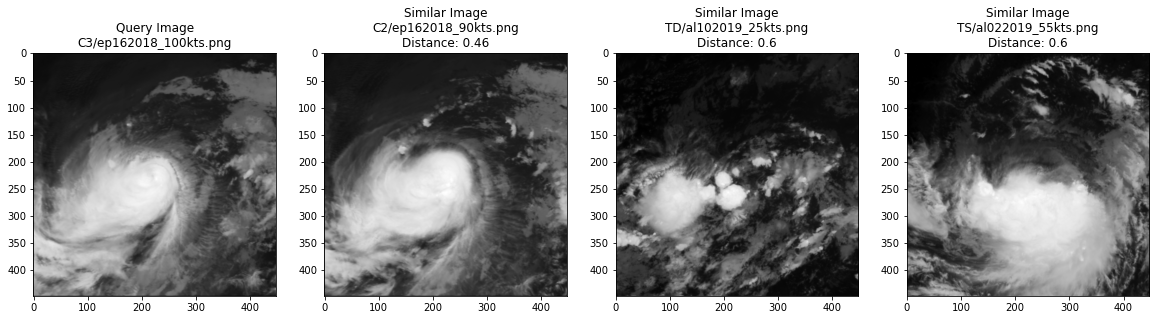

253
[ 253  162 2305 2234 2284 1333 1128 1174  580 1127  883  808  765  331
 1143]
[0.0, 0.6, 0.62, 0.62, 0.63, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.65]
['ep132019_advTime_20190922T120000_goesTime_20190922T142508_intensity_35kts.png',
 'al042018_advTime_20180804T000000_goesTime_20180804T012103_intensity_35kts.png',
 'ep122018_advTime_20180810T180000_goesTime_20180810T232105_intensity_30kts.png',
 'al042018_advTime_20180803T180000_goesTime_20180803T232103_intensity_35kts.png']


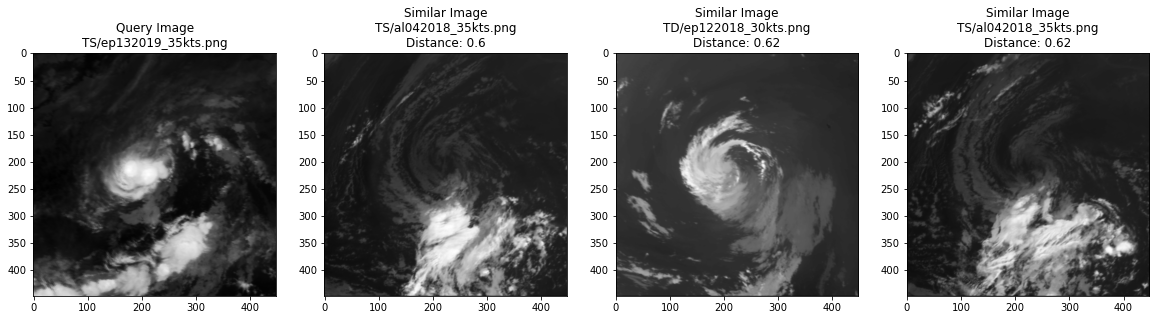

1761
[1761   27 1565 1758  260 1626 1996 1788  397 1375  792  758  523 2559
 1928]
[0.0, 0.74, 0.76, 0.76, 0.76, 0.77, 0.77, 0.78, 0.79, 0.79, 0.8, 0.8, 0.8, 0.81, 0.81]
['al092019_advTime_20190914T000000_goesTime_20190914T002502_intensity_35kts.png',
 'al092019_advTime_20190913T180000_goesTime_20190913T222502_intensity_30kts.png',
 'al092019_advTime_20190914T000000_goesTime_20190914T042502_intensity_35kts.png',
 'al092019_advTime_20190912T120000_goesTime_20190912T172502_intensity_25kts.png']


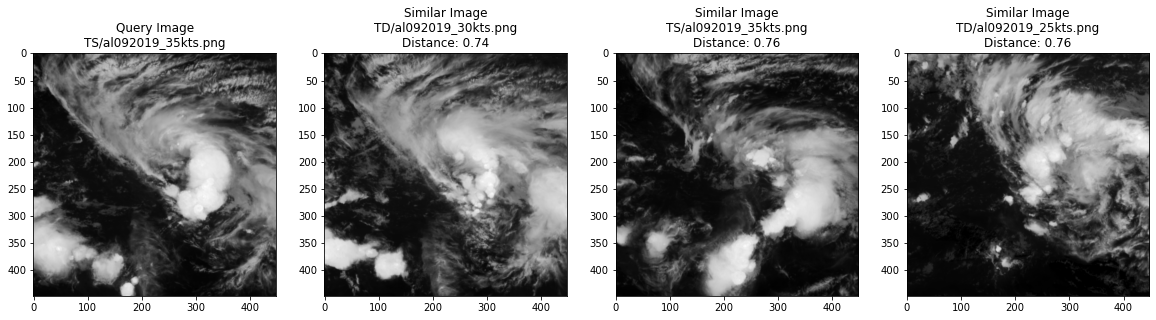

303
[ 303 1627 1529 2526 2355  788 1987  493 1845 2305  490  929 1807  765
  182]
[0.0, 0.5, 0.56, 0.56, 0.56, 0.57, 0.57, 0.57, 0.58, 0.58, 0.58, 0.58, 0.59, 0.59, 0.59]
['ep132019_advTime_20190915T180000_goesTime_20190915T212503_intensity_115kts.png',
 'ep172018_advTime_20180907T180000_goesTime_20180907T182053_intensity_90kts.png',
 'ep172018_advTime_20180905T120000_goesTime_20180905T132054_intensity_95kts.png',
 'ep172018_advTime_20180908T060000_goesTime_20180908T102051_intensity_80kts.png']


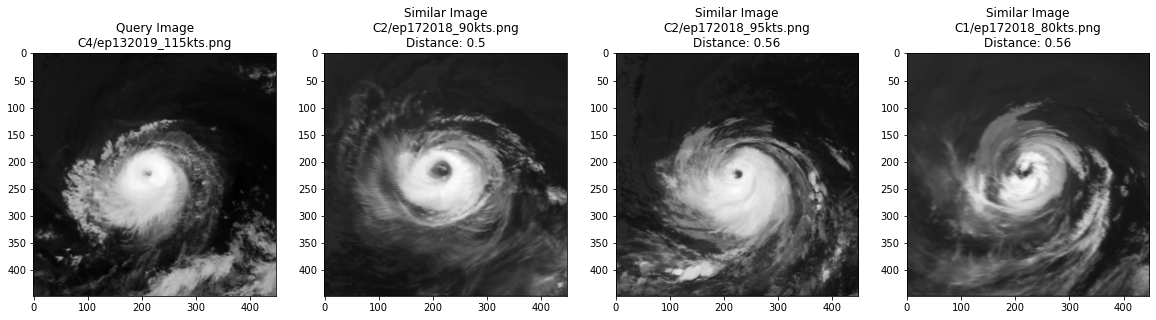

2022
[2022  245  836  309  384 2244  870 1498 1399 2082 1780 2294 2409  137
  688]
[0.0, 0.68, 0.69, 0.7, 0.71, 0.71, 0.72, 0.72, 0.72, 0.72, 0.72, 0.73, 0.74, 0.74, 0.74]
['ep162018_advTime_20180829T180000_goesTime_20180829T202056_intensity_65kts.png',
 'ep132019_advTime_20190918T180000_goesTime_20190918T182505_intensity_55kts.png',
 'ep172018_advTime_20180904T120000_goesTime_20180904T132054_intensity_90kts.png',
 'ep082018_advTime_20180726T120000_goesTime_20180726T152058_intensity_30kts.png']


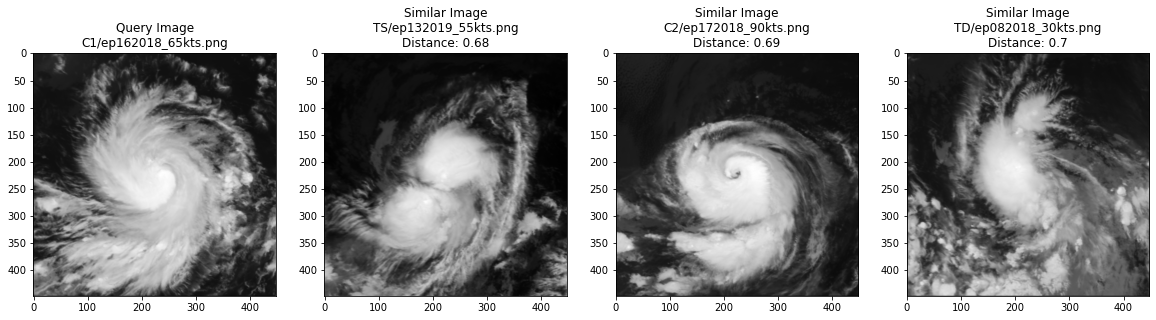

958
[ 958  785 2580 2532  199  312   96  409 1708 2110  302  239 2558 1892
 1844]
[0.0, 0.44, 0.44, 0.44, 0.44, 0.44, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.46, 0.46, 0.47]
['al022018_advTime_20180712T060000_goesTime_20180712T112103_intensity_25kts.png',
 'al042019_advTime_20190823T060000_goesTime_20190823T102508_intensity_25kts.png',
 'al102018_advTime_20180920T180000_goesTime_20180920T202051_intensity_20kts.png',
 'al042019_advTime_20190823T120000_goesTime_20190823T142508_intensity_25kts.png']


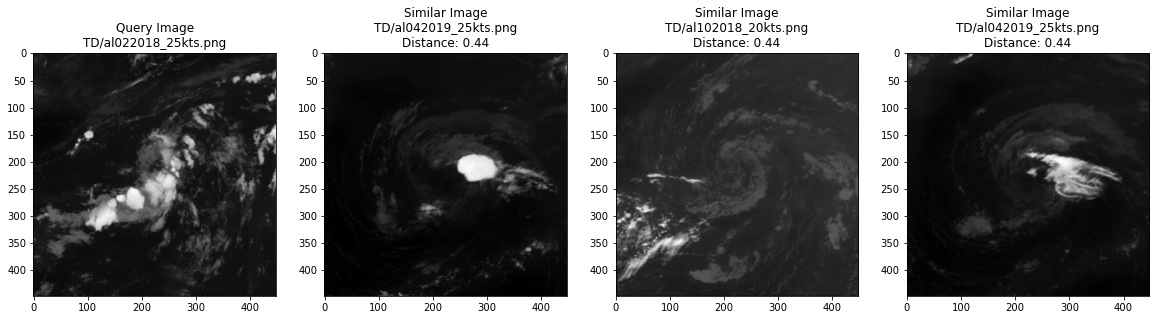

In [7]:
for i in range(6):
    random_image_index = random.randint(0, num_images)
#     random_image_index = 142
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    print(random_image_index)
    print(indices[0][:15])
    print([float("%.2f"%d) for d in distances[0][:15]])
    
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [X_test_paths[random_image_index]] + [X_test_paths[indices[0][i]] for i in range(1, 4)]
    pprint([p.split("/")[-1] for p in similar_image_paths])
    plot_images(similar_image_paths, distances[0], dims=(448, 448, 3))
    plt.show()

In [8]:
neighbors = NearestNeighbors(n_neighbors=len(feature_list),
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors(feature_list)

# Calculating some stats
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ",
      np.median(distances[:, 2]))

Median distance between all photos:  1.072853
Max distance between all photos:  1.7686374
Median distance among most similar photos:  0.53431594


In [9]:
selected_features = feature_list[:]
selected_class_ids = [classname(f) for f in X_test_paths[:]]
selected_filenames = X_test_paths[:]

print(len(selected_features))
print(len(selected_class_ids))
print(len(selected_filenames))

# colors = [b,g,r,c,m,y,k,w]
color_class_map = {"TD": 'b', "TS": 'g', "C1": 'r', "C2": 'c', "C3": 'm', "C4": 'y', "C5": 'k'}
selected_class_ids = [color_class_map[cid] for cid in selected_class_ids]

# print(selected_class_ids)

2623
2623
2623


In [10]:
import time
from sklearn.manifold import TSNE

# You can play with these values and see how the results change
n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(selected_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2623 samples in 1.979s...
[t-SNE] Computed neighbors for 2623 samples in 114.786s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2623
[t-SNE] Computed conditional probabilities for sample 2000 / 2623
[t-SNE] Computed conditional probabilities for sample 2623 / 2623
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.548050
[t-SNE] KL divergence after 1000 iterations: 1.119229
t-SNE done! Time elapsed: 130.09160709381104 seconds


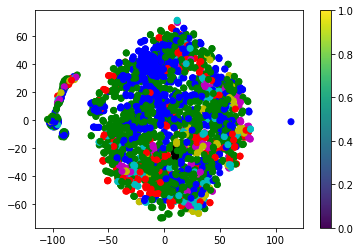

In [11]:
color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=selected_class_ids,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.savefig(FEATURES_PARENT_DIR + "/tSNE_scatter.png")
plt.show()
# To save the plot in a high definition format i.e. PDF, uncomment the following line:


In [12]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

dims=(448, 448, 3)
def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
#         if y0 > 100:
#             print("WEIIRRDDDD ===>>>>", image_path)
        image = Image.fromarray(np.uint8(resize(plt.imread((image_path))[:,:,:3], dims)*255))
#         image = Image.fromarray(np.uint8(np.load(image_path)*255))
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [13]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.savefig(FEATURES_PARENT_DIR + "/tSNE_img_scatter.png")
    plt.show()

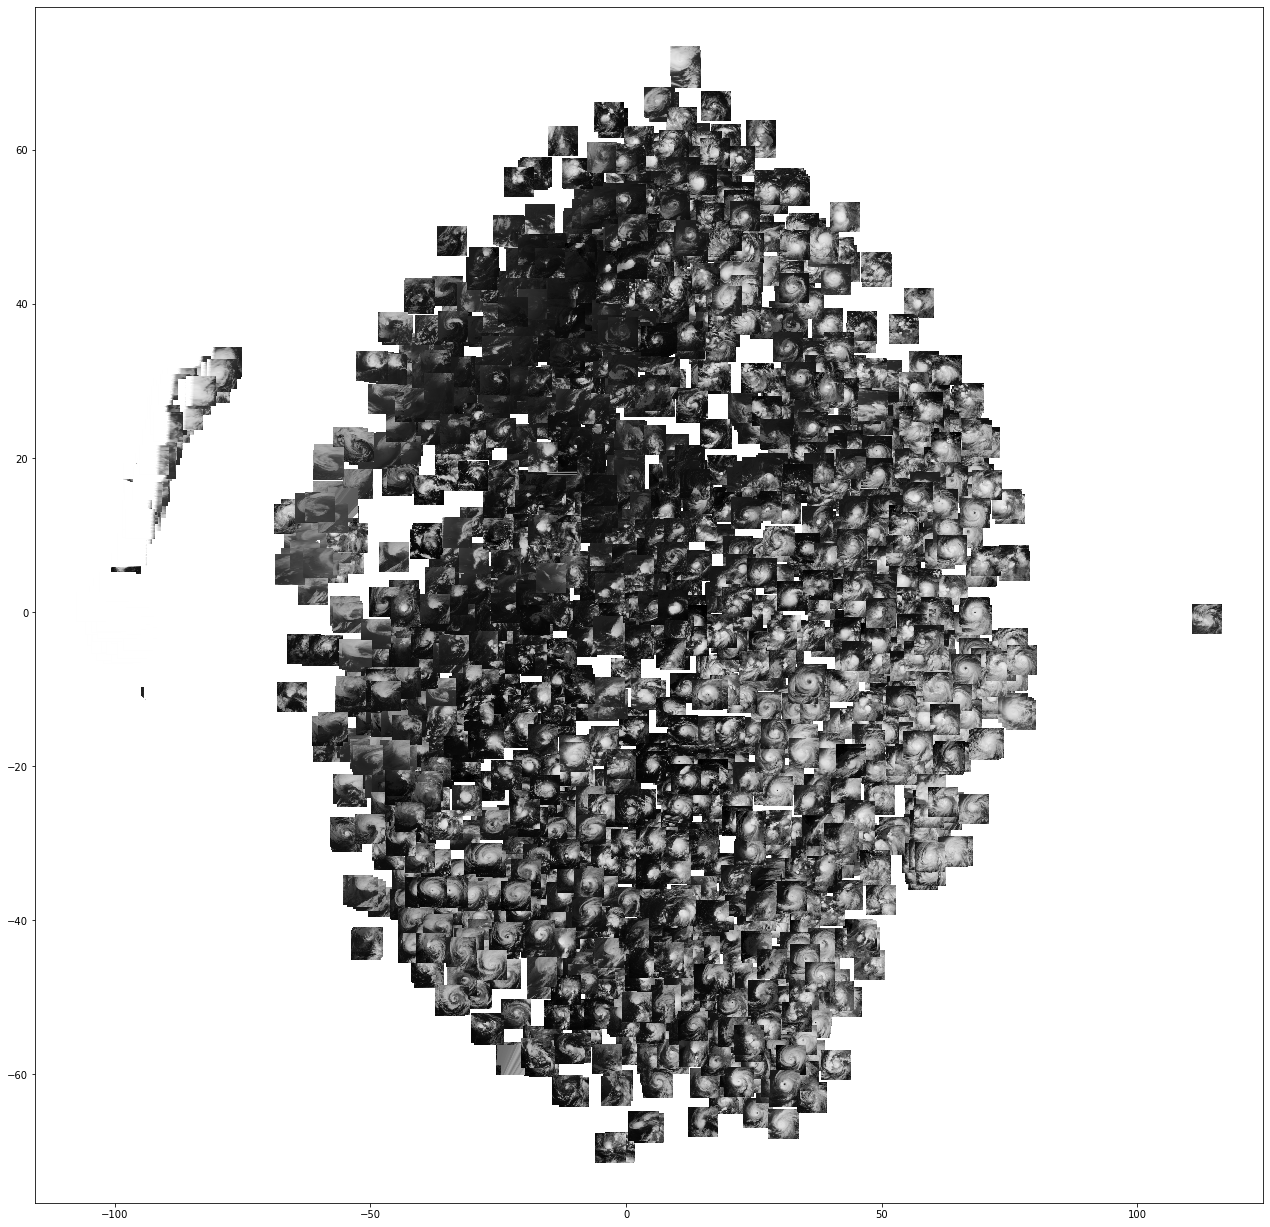

In [14]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

In [15]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.savefig(FEATURES_PARENT_DIR + "/tSNE_img_grid.png")
    plt.show()

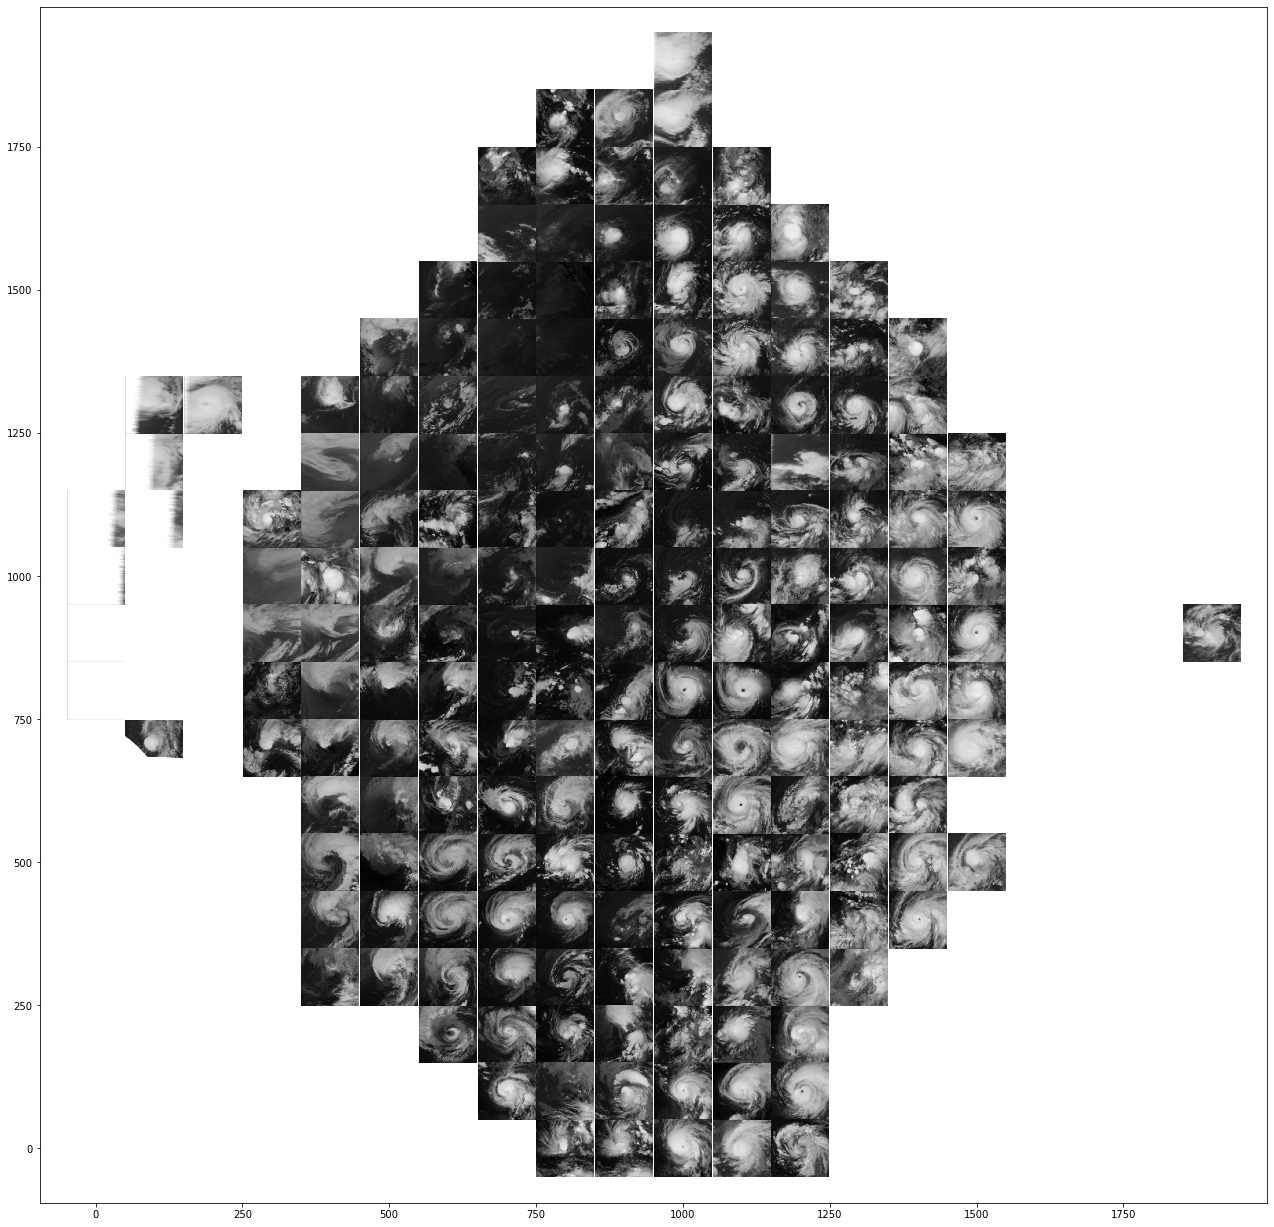

In [16]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)